**Fitting the data into the models - Part 2**

Using RandomizedSearchCV as hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cleaned_data_v2.csv')


HYPERPARAMETER TUNING:
Fitting 5 folds for each of 150 candidates, totalling 750 fits

Best parameters found:
  splitter: best
  min_samples_split: 30
  min_samples_leaf: 10
  min_impurity_decrease: 0.001
  max_features: 0.5
  max_depth: 3
  criterion: entropy
  ccp_alpha: 0.01

MODEL COMPARISON:

Initial Decision Tree:
(1) Training Accuracy:   0.9152
(2) Test Accuracy:       0.8800
(3) Validation Accuracy: 0.9200

Tuned Decision Tree:
(1) Training Accuracy:   0.8884
(2) Test Accuracy:       0.9067
(3) Validation Accuracy: 0.9333

FINAL MODEL SELECTION:
Best model based on validation accuracy: Tuned Decision Tree
Validation accuracy: 0.9333

MODEL PERFORMANCE:
(1) Training Accuracy: 0.8884
(2) Test Accuracy: 0.9067
(3) Validation Accuracy: 0.9333

CLASSIFICATION REPORT - TEST SET:
                   precision    recall  f1-score   support

         Insomnia       0.92      0.80      0.86        15
No Sleep Disorder       0.95      0.95      0.95        44
      Sleep Apnea       0.78 

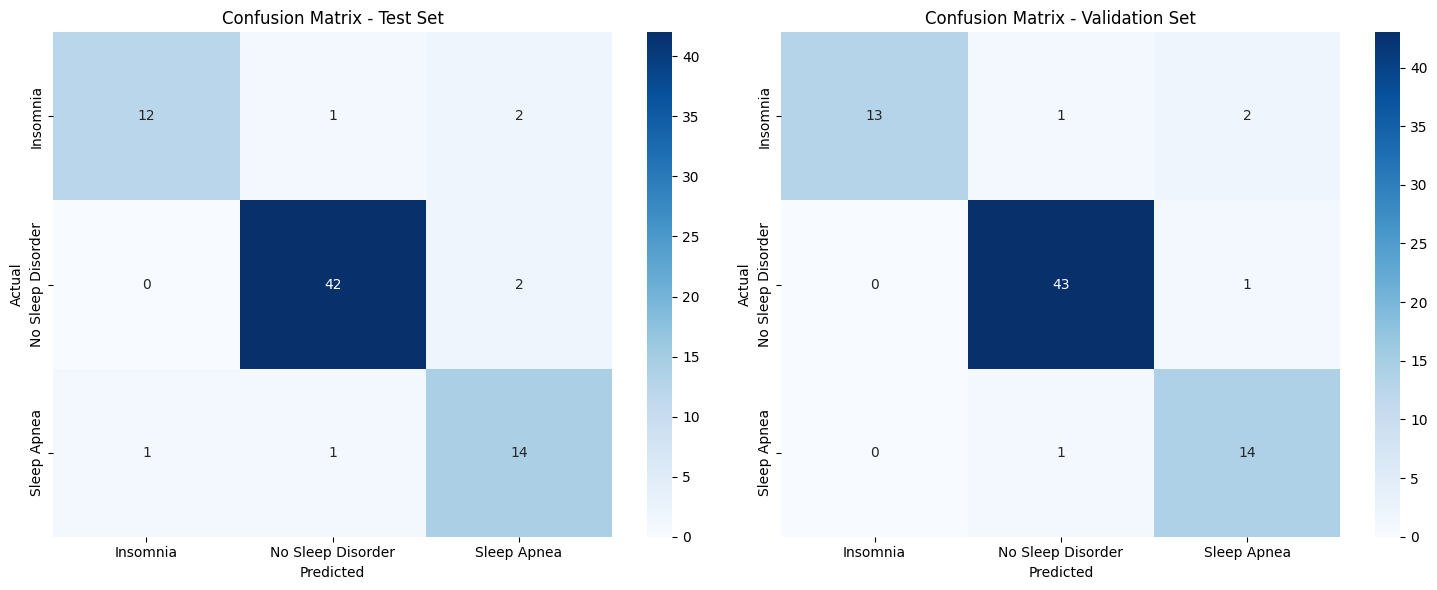

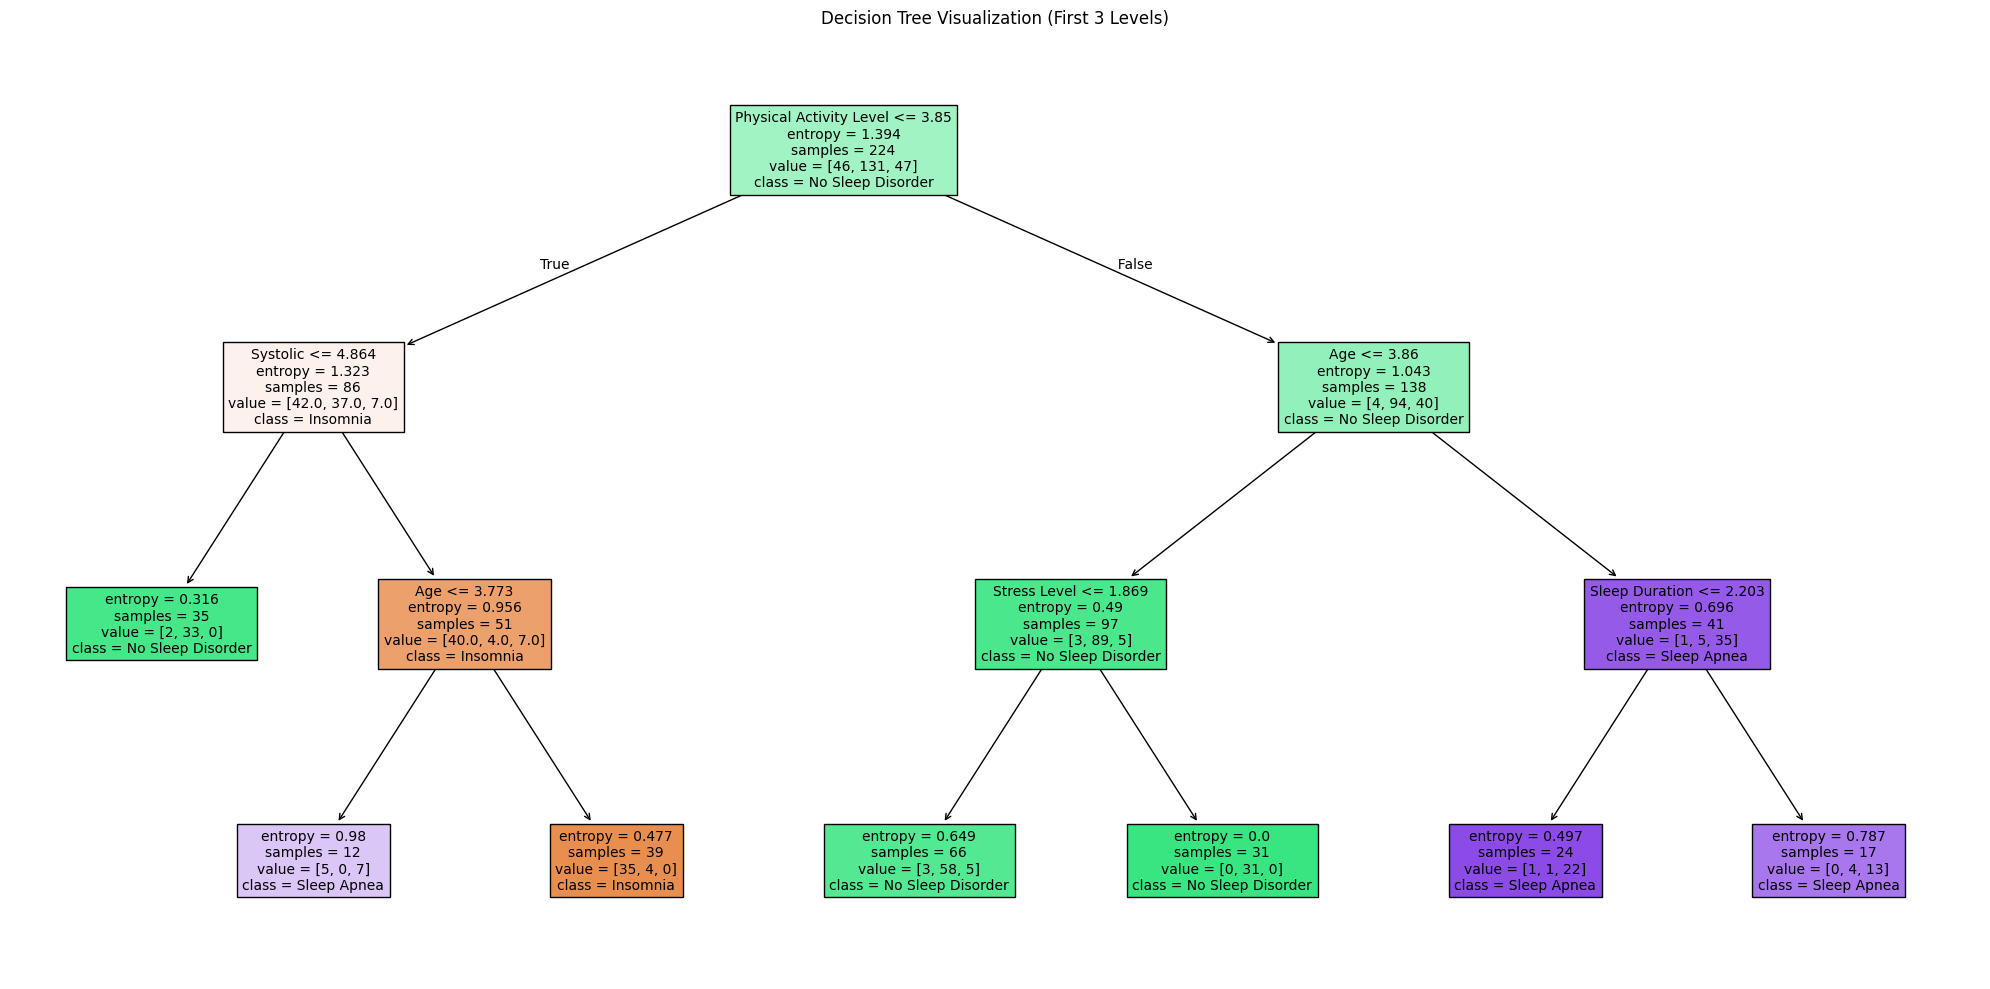

In [6]:
# Define features (X) and target (y)
X = df.drop('Sleep Disorder', axis=1) # Assuming 'Sleep Disorder' is the target column
y = df['Sleep Disorder']

# Encode target variable because it is categorical
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into train, test, and validation sets
# First split: 60% train, 40% temp (which will be split into test and validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)

# Second split: Split the temp 40% into 20% test and 20% validation
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


# ============================================================================
# HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH
# ============================================================================


print("\nHYPERPARAMETER TUNING:")


# Define comprehensive parameter distribution for RandomizedSearchCV
param_dist = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.9],
    'splitter': ['best', 'random'],
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
}


# Base Decision Tree for comparison
base_dt = DecisionTreeClassifier(random_state=42)

# RandomizedSearchCV with extended search

random_search = RandomizedSearchCV(
    base_dt,
    param_dist,
    n_iter=150,  # Number of parameter combinations to try
    cv=5,        # 5-fold cross validation
    scoring='accuracy',
    n_jobs=-1,   # Use all available cores
    random_state=42,
    verbose=2    # More detailed output
)

random_search.fit(X_train, y_train)

print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Get the best model
best_tuned_model = random_search.best_estimator_

# Create models for comparison
models = {
    'Initial Decision Tree': DecisionTreeClassifier(
        random_state=42, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, criterion='gini'
    ),
    'Tuned Decision Tree': best_tuned_model
}

# Compare all models

print("\nMODEL COMPARISON:")


model_results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    val_pred = model.predict(X_val)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    val_acc = accuracy_score(y_val, val_pred)

    # Calculate overfitting metric (difference between train and validation)
    overfitting = train_acc - val_acc

    model_results[name] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'val_acc': val_acc,
        'overfitting': overfitting,
        'model': model
    }

    print(f"\n{name}:")
    print(f"(1) Training Accuracy:   {train_acc:.4f}")
    print(f"(2) Test Accuracy:       {test_acc:.4f}")
    print(f"(3) Validation Accuracy: {val_acc:.4f}")


# Select the best performing model on validation set
best_val_model_name = max(model_results.keys(), key=lambda x: model_results[x]['val_acc'])
best_final_model = model_results[best_val_model_name]['model']


print("\nFINAL MODEL SELECTION:")
print(f"Best model based on validation accuracy: {best_val_model_name}")
print(f"Validation accuracy: {model_results[best_val_model_name]['val_acc']:.4f}")

# Use the best model for final evaluation
dt_classifier = best_final_model

# Make predictions on all sets
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)
y_val_pred = dt_classifier.predict(X_val)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)


print("\nMODEL PERFORMANCE:")
print(f"(1) Training Accuracy: {train_accuracy:.4f}")
print(f"(2) Test Accuracy: {test_accuracy:.4f}")
print(f"(3) Validation Accuracy: {val_accuracy:.4f}")


# Classification Report for Test Set
print("\nCLASSIFICATION REPORT - TEST SET:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


# Classification Report for Validation Set
print("\nCLASSIFICATION REPORT - VALIDATION SET:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# Confusion Matrix for Test Set
print("\nCONFUSION MATRIX - TEST SET:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)


# Confusion Matrix for Validation Set
print("\nCONFUSION MATRIX - VALIDATION SET:")
cm_val = confusion_matrix(y_val, y_val_pred)
print(cm_val)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Test set confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax1)
ax1.set_title('Confusion Matrix - Test Set')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Validation set confusion matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax2)
ax2.set_title('Confusion Matrix - Validation Set')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Visualize the decision tree (first few levels)
plt.figure(figsize=(20, 10))
tree.plot_tree(dt_classifier,
               feature_names=X.columns,
               class_names=le.classes_,
               filled=True,
               max_depth=3,  # Show only first 3 levels for readability
               fontsize=10)
plt.title('Decision Tree Visualization (First 3 Levels)')
plt.tight_layout()
plt.show()